# Docking Proteína Ligando
* Based in https://www.wildcardconsulting.dk/ligand-docking-with-smina
* Laboratorio Nanocell
* http://www.nanocell.cl
* Dr. Alexis Salas Burgos
* Junio 2019

# Vina
## http://vina.scripps.edu

## Instalar dependencias con conda

In [ ]:
!conda create -n docking jupyterlab -y
!conda install biopandas -y
!conda install -c schrodinger pymol -y
!conda install -c openbabel openbabel -y
!conda install -c bioconda autodock-vina
!conda install -c bioconda smina

In [ ]:
# Download Vina 

In [ ]:
# Baje la versión de acuerdo a su sistema operativo
!wget http://vina.scripps.edu/download/autodock_vina_1_1_2_win32.msi
!wget http://vina.scripps.edu/download/autodock_vina_1_1_2_linux_x86.tgz    
!wget http://vina.scripps.edu/download/autodock_vina_1_1_2_mac.tgz
    
# Esta es una variante de vina con mejoras en las funciones de scoring
# Download Smina
!wget https://sourceforge.net/projects/smina/files/smina.osx/download
!wget https://sourceforge.net/projects/smina/files/smina.static/download  

## Preparar Receptor y Ligando con Pymol
* https://pymol.org/2

In [26]:
from pymol import cmd
cmd.delete('all')
cmd.fetch('1oyt')

'1oyt'

In [27]:
cmd.do('''
remove resn HOH
h_add elem O or elem N
select 1OYT-FSN, resn FSN #Create a selection called 1OYT-FSN from the ligand
select 1OYT-receptor, 1OYT and not 1OYT-FSN #Select all that is not the ligand
save 1OYT-FSN.pdb, 1OYT-FSN
save 1OYT-receptor.pdb, 1OYT-receptor
''')

 Save: wrote "1OYT-FSN.pdb".
 Save: wrote "1OYT-receptor.pdb".


In [28]:
cmd.do('''
bg_color white
remove solvent
extract ligands,het
as surface, 1oyt
set transparency,0.5
as sticks, ligands
show stick, byres(1yot w. 4 of ligands)
center ligands
origin ligands
zoom ligands
dist hbo,1yop,ligands,3.2,mode=2
ray
png pic1.png
''')

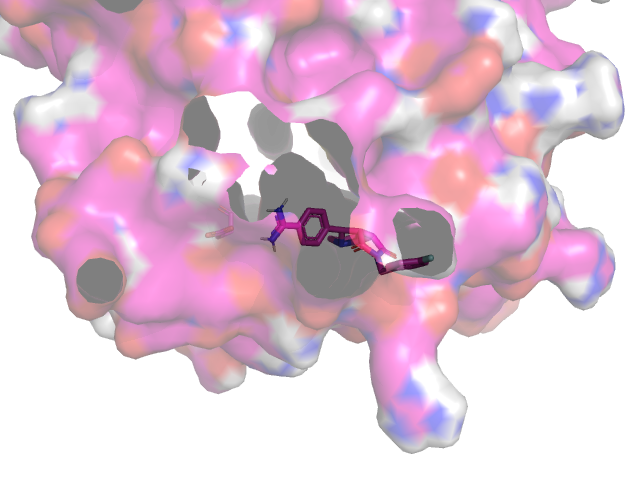

In [29]:
from IPython.display import Image
Image(filename='pic1.png')

## Agregar las cargas y torsiones con openbabel
* https://openbabel.org

In [15]:
#!obabel 1OYT-receptor.pdb -xr -O 1OYT-receptor.pdbqt
#!obabel 1OYT-FSN.pdb -O 1OYT-FSN.pdbq

In [30]:
from openbabel import OBMol, OBConversion, OBElementTable
from openbabel import OBMolAtomIter, OBAtomBondIter, OBForceField

In [31]:
obconversion = OBConversion()
obconversion.SetInAndOutFormats("pdb", "pdbqt")  # Set input and output formats

True

In [18]:
def topdbqt(mol_file):
    output = mol_file.split(".")[0]+".pdbqt"
    obmol = OBMol()                                # Create openbabel molecule instance
    obconversion.ReadFile(obmol, mol_file)         # Read file (file is read into obmol object)
    obconversion.WriteFile(obmol, output)   # Convert file to output format and save
    return

In [32]:
topdbqt(mol_file="1OYT-FSN.pdb")
topdbqt(mol_file="1OYT-receptor.pdb")

## Run Vina

Input:
  --receptor arg        rigid part of the receptor (PDBQT)
  --flex arg            flexible side chains, if any (PDBQT)
  --ligand arg          ligand (PDBQT)

Search space (required):
  --center_x arg        X coordinate of the center
  --center_y arg        Y coordinate of the center
  --center_z arg        Z coordinate of the center
  --size_x arg          size in the X dimension (Angstroms)
  --size_y arg          size in the Y dimension (Angstroms)
  --size_z arg          size in the Z dimension (Angstroms)

## Usando Biopandas
* https://rasbt.github.io/biopandas

In [43]:
from biopandas.pdb import PandasPdb
ppdb = PandasPdb().read_pdb('1OYT-FSN.pdbqt')
ppdb.df['ATOM'].head()

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,...,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,ATOM,1,,C,,UNL,,,1,,...,15.863,-11.337,20.194,0.0,0.0,+0,.089,C,NaN,10
1,ATOM,2,,N,,UNL,,,1,,...,15.799,-12.440,19.140,0.0,0.0,-0,.271,N,NaN,11
2,ATOM,3,,C,,UNL,,,1,,...,17.217,-12.198,18.600,0.0,0.0,+0,.067,C,NaN,12
3,ATOM,4,,C,,UNL,,,1,,...,18.245,-11.812,19.663,0.0,0.0,+0,.102,C,NaN,13
4,ATOM,5,,C,,UNL,,,1,,...,19.064,-12.906,20.178,0.0,0.0,+0,.233,C,NaN,14


In [48]:
reference_point = (9.362, 41.410, 10.542)
distances = ppdb.distance(xyz=reference_point, records=('ATOM',))
ppdb

('ATOM',)

In [ ]:
import os
#from conda
vina = "vina"
cmd = "%s -r 1OYT-receptor.pdbqt -l 1OYT-FSN.pdbqt \
--autobox_ligand 1OYT-FSN.pdbqt --autobox_add 8 --exhaustiveness 16 \
-o 1OYT-redock.pdbqt" % smina
print(cmd)
os.system(cmd)

## Run Smina

In [49]:
import os
smina = "smina"
cmd = "%s -r 1OYT-receptor.pdbqt -l 1OYT-FSN.pdbqt \
--autobox_ligand 1OYT-FSN.pdbqt --autobox_add 8 --exhaustiveness 16 \
-o 1OYT-redock.pdbqt --log redock.out" % smina
print(cmd)
os.system(cmd)

smina -r 1OYT-receptor.pdbqt -l 1OYT-FSN.pdbqt --autobox_ligand 1OYT-FSN.pdbqt --autobox_add 8 --exhaustiveness 16 -o 1OYT-redock.pdbqt --log redock.out


0

In [36]:
# Explore el archivo de 1OYT-redock.pdbqt
%cat 1OYT-redock.pdbqt

MODEL 1
REMARK minimizedAffinity -11.2001896
REMARK minimizedRMSD -1
REMARK  Name = 1OYT-FSN.pdb
REMARK  4 active torsions:
REMARK  status: ('A' for Active; 'I' for Inactive)
REMARK    1  A    between atoms: _3  and  _4
REMARK    2  A    between atoms: _7  and  _10
REMARK    3  A    between atoms: _19  and  _23
REMARK    4  A    between atoms: _23  and  _24
REMARK                            x       y       z     vdW  Elec       q    Type
REMARK                         _______ _______ _______ _____ _____    ______ ____
ROOT
ATOM      1  C   UNL     1      16.037 -11.441  19.999  0.00  0.00    +0.089 C 
ATOM      2  N   UNL     1      16.013 -12.577  18.978  0.00  0.00    -0.271 NA
ATOM      3  C   UNL     1      17.448 -12.346  18.480  0.00  0.00    +0.067 C 
ATOM      4  C   UNL     1      18.438 -11.922  19.565  0.00  0.00    +0.102 C 
ATOM      5  C   UNL     1      19.242 -12.996  20.142  0.00  0.00    +0.233 C 
ATOM      6  N   UNL     1      18.668 -13.382  21.387  0.00  0.00    -

In [ ]:
# Use la terminal
#view results in pymol
pymol 1OYT-receptor.pdb 1OYT-redock.pdbqt 1OYT-FSN.pdb

# Calcule los RMSD con biopandas

In [ ]:
from biopandas.pdb import PandasPdb
pl1 = PandasPdb().read_pdb('./docking_pose_1.pdb')
pl2 = PandasPdb().read_pdb('./docking_pose_2.pdb')
r = PandasPdb.rmsd(pl1.df['HETATM'], pl2.df['HETATM'])
print('RMSD: %.4f Angstrom' % r)